In [139]:
import datetime

import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import pandas_datareader.data as web
import seaborn as sns
import yfinance as yfin
import matplotlib.pyplot as plt
from scipy import stats

# Market data
## scenario 1: loan for a credit card (unsecured)
Delinquency rates on credit cards from FRED: https://fred.stlouisfed.org/series/DRCCLACBS

## scenario 2: loan for a house in California (collateral is the house)

Average 30y mortgage rate from FRED: https://fred.stlouisfed.org/series/MORTGAGE30US 

Mortgage delinquency rate from FRED: https://fred.stlouisfed.org/series/DRSFRMACBS

House price index for California from FRED: https://fred.stlouisfed.org/series/CASTHPI

## scenario 3: loan to a construction company (collateral is the building under construction, but not the land)

Building material prices from FRED: https://fred.stlouisfed.org/series/PCU44414441

## scenario 4: sp500 index

S&P500 index as a public traded equity from FRED: https://fred.stlouisfed.org/series/sp500 (fred)

## scenario 5: treasury bond with 30y maturity

30y treasury yield from Yahoo!Finance: https://finance.yahoo.com/quote/%5ETYX?p=%5ETYX

## scenario 6: illiquid corporate bond of high quality company

Since the bond is illiquid and of investment grade, we use as proxy the aggregated bond yield index for companies with Moody's rating A or above from FRED: https://fred.stlouisfed.org/series/DAAA

In [245]:
# Renaming the data for easier interpretation, with data frequency
column_name_mapping = {
    'DRCCLACBS': 'CreditCardDelinq (quarterly)', 
    'MORTGAGE30US': 'AvgMortgageRate (weekly)',
    'DRSFRMACBS': 'MortgageDelinq (quarterly)',
    'CASTHPI': 'HousePxIdx_CA (quarterly)',
    'PCU44414441': 'BuildingMaterialPx (monthly)',
    'sp500': 'SP500 (daily)',
    'DAAA': 'InvestmentBondYield (daily)',
    '^TYX': 'TreasuryBondYield (daily)'
}

In [247]:
end = datetime.date.today() #coded on 10/Jan/2024
start = end - datetime.timedelta(365 * 10)
df = web.DataReader(['DRCCLACBS', 'MORTGAGE30US', 'DRSFRMACBS', 'CASTHPI', 'PCU44414441', 'sp500', 'DAAA'], 'fred', start, end)
df['^TYX'] = yfin.download('^TYX', start=start, end=end)['Adj Close']
df.rename(columns=column_name_mapping, inplace=True)
df.head()

[*********************100%%**********************]  1 of 1 completed


,CreditCardDelinq (quarterly),AvgMortgageRate (weekly),MortgageDelinq (quarterly),HousePxIdx_CA (quarterly),BuildingMaterialPx (monthly),SP500 (daily),InvestmentBondYield (daily),TreasuryBondYield (daily)
DATE,,,,,,,,
2014-01-13,NaN,NaN,NaN,NaN,NaN,1819.20,4.47,3.767
2014-01-14,NaN,NaN,NaN,NaN,NaN,1838.88,4.50,3.800
2014-01-15,NaN,NaN,NaN,NaN,NaN,1848.38,4.50,3.806
2014-01-16,NaN,4.41,NaN,NaN,NaN,1845.89,4.48,3.773
2014-01-17,NaN,NaN,NaN,NaN,NaN,1838.70,4.47,3.757


## Plot all the time series for visualisation

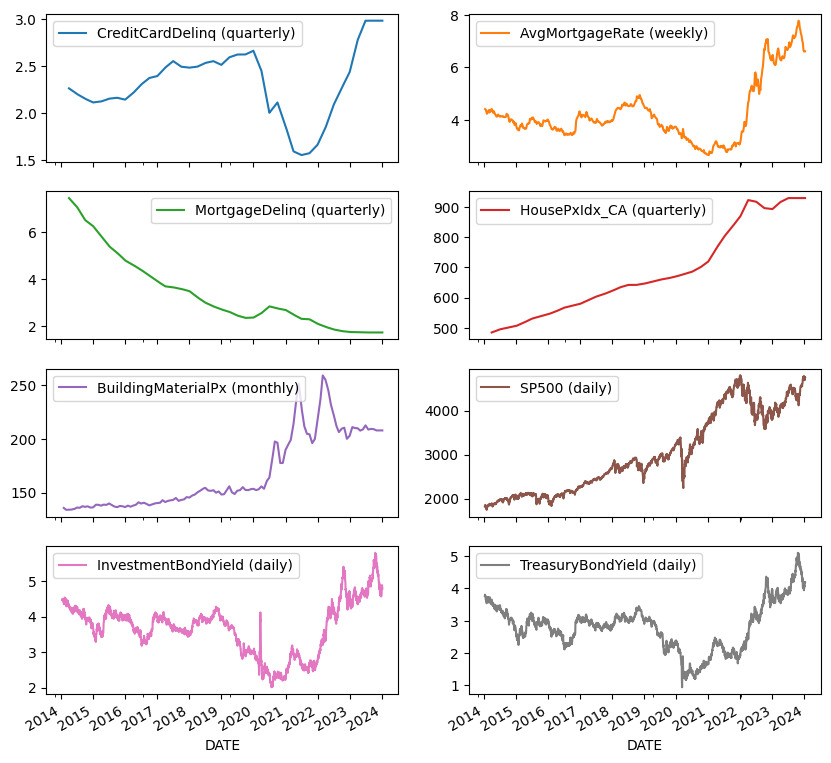

In [248]:
#interpolate on the dates just for plotting
df_interpolated = df.interpolate('index')
df_interpolated.plot(subplots=True, layout=(4,2), figsize=(10,10));

In [249]:
# The below columns have date indices on the first of the month, which may not be a business day.
# We bump their index to the next business day to better align their valid dates to those of other series (e.g. sp500).
for feature in ['BuildingMaterialPx (monthly)', 'HousePxIdx_CA (quarterly)', 'MortgageDelinq (quarterly)', 'CreditCardDelinq (quarterly)']:
    clean_series = df[feature].dropna()
    df[feature] = pd.Series(clean_series.values, index=[d + BDay(0) for d in clean_series.index])

In [250]:
df.head()

,CreditCardDelinq (quarterly),AvgMortgageRate (weekly),MortgageDelinq (quarterly),HousePxIdx_CA (quarterly),BuildingMaterialPx (monthly),SP500 (daily),InvestmentBondYield (daily),TreasuryBondYield (daily)
DATE,,,,,,,,
2014-01-13,NaN,NaN,NaN,NaN,NaN,1819.20,4.47,3.767
2014-01-14,NaN,NaN,NaN,NaN,NaN,1838.88,4.50,3.800
2014-01-15,NaN,NaN,NaN,NaN,NaN,1848.38,4.50,3.806
2014-01-16,NaN,4.41,NaN,NaN,NaN,1845.89,4.48,3.773
2014-01-17,NaN,NaN,NaN,NaN,NaN,1838.70,4.47,3.757


## Calculate returns
Care must be taken as different features have returns in different time horizons. So we calculate returns for each time granuarity in our dataset.

We avoid casting low-frequency data into higher frequency (e.g. quarterly to daily) because this would be too crude.

In [253]:
def calculate_returns(df):
    df_returns = np.log(df)-np.log(df.shift(1))
    return df_returns.dropna()

# drop mortgage rate as its indices do not align with the quarterly data
df_quarterly = df.drop(columns='AvgMortgageRate (weekly)').loc[df['CreditCardDelinq (quarterly)'].dropna().index].ffill()
df_monthly = df.loc[df['BuildingMaterialPx (monthly)'].dropna().index, 
                                                             ['SP500 (daily)','InvestmentBondYield (daily)', 
                                                              'BuildingMaterialPx (monthly)','TreasuryBondYield (daily)']].ffill()
df_weekly = df.loc[df['AvgMortgageRate (weekly)'].dropna().index, 
                   ['AvgMortgageRate (weekly)','SP500 (daily)','InvestmentBondYield (daily)', 'TreasuryBondYield (daily)']].ffill()
df_daily = df.loc[df['SP500 (daily)'].dropna().index, ['SP500 (daily)','InvestmentBondYield (daily)','TreasuryBondYield (daily)']].ffill()

df_quarterly_returns = calculate_returns(df_quarterly)
df_monthly_returns = calculate_returns(df_monthly)
df_weekly_returns = calculate_returns(df_weekly)
df_daily_returns = calculate_returns(df_daily)
df_daily_returns.head()

,SP500 (daily),InvestmentBondYield (daily),TreasuryBondYield (daily)
DATE,,,
2014-01-14,0.010760,0.006689,0.008722
2014-01-15,0.005153,0.000000,0.001578
2014-01-16,-0.001348,-0.004454,-0.008708
2014-01-17,-0.003903,-0.002235,-0.004250
2014-01-21,0.002770,-0.002240,-0.004803


## Plot a heatmap of the correlation matrix of log-returns
The correlations for quarterly data would no be reliable as we have no more than 40 datapoints to calculate it. Even going from weekly to daily data can have considerable impact. In fact, notice that the correlation beween the sp500 and bond yields is negative for weekly data but positive for daily data. The comparison between monthly and daily data is even more striking as the correlation goes from strong negative to small positive.

Building material prices are somewhat positively correlated to sp500 returns and bond yields, which may be explained by inflation (notice that higher inflation pushes the nominal interest rates higher).

Average mortgage rates are positively correlated with bond yields, which is intuitive since higher interest rates translates into higher mortgage rates. Mortgage rates are negatively correlated with sp500 returns, implying that more money is being spent in repaying loans than in equity investment.

Unsurprisingly, treasury bond yield returns are strongly correlated with investment bond yield returns.

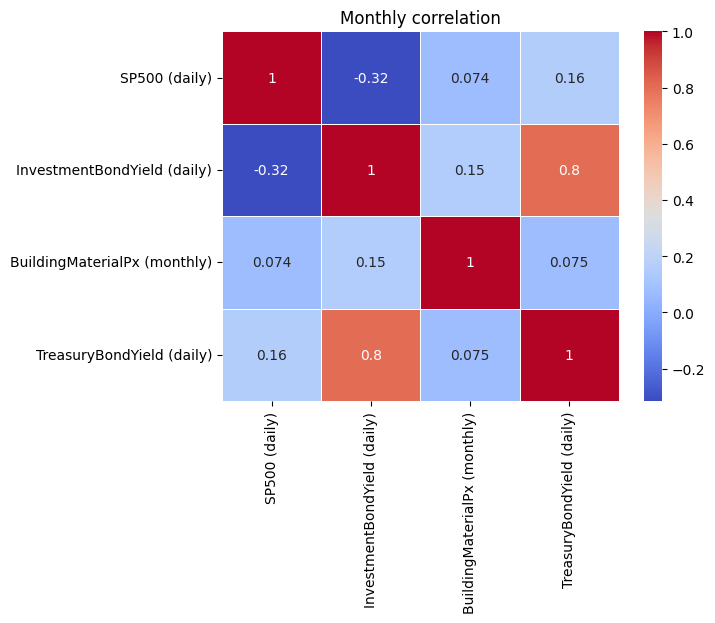

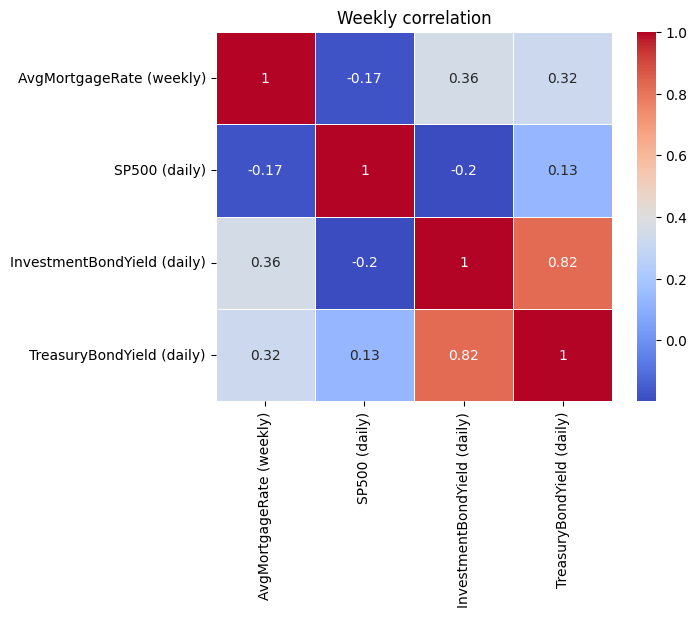

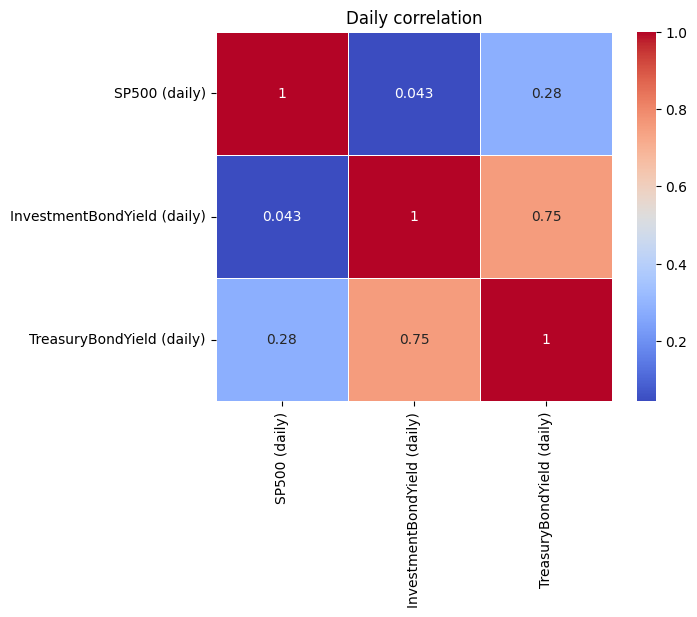

In [254]:
def plot_correlation_heatmap(df_ret, title):
    corr_matrix = df_ret.corr().round(3)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title(title)
    plt.show();
plot_correlation_heatmap(df_monthly_returns, 'Monthly correlation')
plot_correlation_heatmap(df_weekly_returns, 'Weekly correlation')
plot_correlation_heatmap(df_daily_returns, 'Daily correlation')

A regression plot illustrates the correlation between yield returns of investment grade bonds and treasury.

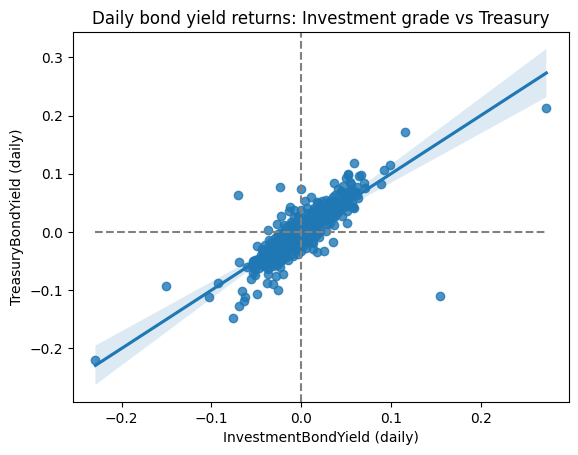

In [255]:
sns.regplot(x='InvestmentBondYield (daily)', y='TreasuryBondYield (daily)', data=df_weekly_returns).set(
    title="Daily bond yield returns: Investment grade vs Treasury"
)

plt.axvline(0, 0, 1, dash_capstyle="butt", linestyle="--", color="grey")
plt.plot([min(df_weekly_returns['InvestmentBondYield (daily)']), max(df_weekly_returns['InvestmentBondYield (daily)'])], 
         [0, 0], linestyle="--", color="grey");

## Statistical analysis of daily returns

The basic statistics for the sp500 and bond yield returns show a negative skew for the equity and positive skew for the bond. In particular, we see that the median of sp500 returns is greater than the mean wheres the opposite applies to the investment bond yields. Interestingly, treasury bond yields have a mean higher than the median despite having negative skew. This can be explained by the very high kurtosis, whereby a small number of extremely positive outliers pull the mean higher than the median despite the negative skew.

This illustrates the fact that equities may contain large negative jumps but steadier recoveries, as we can see in the sp500 series plot during/post the covid pandemic period.

In [256]:
print(df_daily_returns.skew().rename('skew'))
df_daily_returns.describe()

SP500 (daily)                 -0.808339
InvestmentBondYield (daily)    0.622609
TreasuryBondYield (daily)     -0.386500
Name: skew, dtype: float64


,SP500 (daily),InvestmentBondYield (daily),TreasuryBondYield (daily)
count,2514.000000,2514.000000,2514.000000
mean,0.000382,0.000028,0.000042
std,0.011217,0.015412,0.021926
min,-0.127652,-0.143288,-0.259816
25%,-0.003816,-0.008202,-0.010446
50%,0.000600,0.000000,-0.000438
75%,0.005652,0.008021,0.010805
max,0.089683,0.165985,0.263103


The excess kurtosis for the equity and bond yield returns are huge, showing the presence of fatter tails compared to the normal distribution, that is to say, extreme events (covid pandemic being a good example) are more likely than one would expect from the normal distribution.
We have seen in the lecture notes that sp500 log-returns are not normal. Let us carry out a similar analysis for the bond yield.

In [257]:
print(df_daily_returns.kurt().rename('kurtosis'))

SP500 (daily)                  16.062571
InvestmentBondYield (daily)    13.268156
TreasuryBondYield (daily)      28.992039
Name: kurtosis, dtype: float64


The histogram plots show the skewness present in both data sets. It also show the presence of some extreme outliers, illustrating the high kurtosis mentioned above.

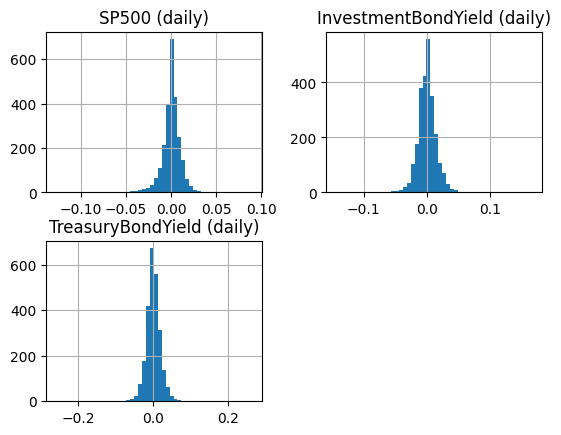

In [259]:
df_daily_returns.hist(bins=50);

The KDE plot of the normal distribution with same mean and variance as the bond yield returns is quite different from the normalized histogram of the sapled data. More specifically, the histogram has a slightly positive skew (to the right), fatter tails (high kurtosis) and a spikier peak around the mean.

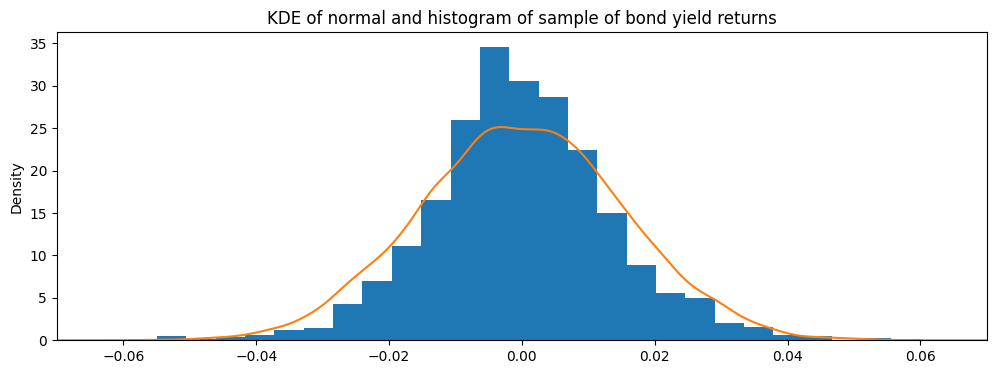

In [269]:
bond_yield_rets = df_daily_returns['InvestmentBondYield (daily)']
np.random.seed(52)
normal_dist = stats.norm.rvs(
    size=20_000, loc=bond_yield_rets.mean(), scale=bond_yield_rets.std()
)
bond_yield_rets.hist(bins=70, density=True)
pd.Series(normal_dist).plot(kind="kde", xlim=(-0.07, 0.07), figsize=(12, 4));
plt.title('KDE of normal and histogram of sample of bond yield returns');

We finally carry out two normality tests showing a very low p-value to confirm what we already know: the normal distribution is innapropriate to model the bond yield returns.

In [267]:
print("D'Agostino and Pearson p-value: ", stats.normaltest(bond_yield_rets).pvalue)
print("Jarque-Bera p-value: ", stats.jarque_bera(bond_yield_rets).pvalue)

D'Agostino and Pearson p-value:  5.101260582424045e-144
Jarque-Bera p-value:  0.0
